In [26]:
# (1) 설치 전, 기존 라이브러리 제거:
!pip uninstall -y numpy scipy gensim

# (2) 설치: numpy는 gensim이 2.0 미만을 요구하므로 1.x 버전으로 깔아주는 게 좋습니다.
!pip install "numpy<2.0,>=1.18.5"  # 예: numpy 1.26.x
!pip install "gensim==4.3.3"
!pip install konlpy pyLDAvis openpyxl networkx seaborn

# 한글 폰트
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: scipy 1.13.1
Uninstalling scipy-1.13.1:
  Successfully uninstalled scipy-1.13.1
Found existing installation: gensim 4.3.3
Uninstalling gensim-4.3.3:
  Successfully uninstalled gensim-4.3.3


ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


  Using cached gensim-4.3.3-cp310-cp310-win_amd64.whl.metadata (8.2 kB)
  Using cached numpy-1.26.4-cp310-cp310-win_amd64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp310-cp310-win_amd64.whl.metadata (60 kB)
Using cached gensim-4.3.3-cp310-cp310-win_amd64.whl (24.0 MB)
Using cached numpy-1.26.4-cp310-cp310-win_amd64.whl (15.8 MB)
Using cached scipy-1.13.1-cp310-cp310-win_amd64.whl (46.2 MB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
atlite 0.4.0 requires xarray>=2024.03.0, but you have xarray 2023.11.0 which is incompatible.
rioxarray 0.18.1 requires xarray>=2024.7.0, but you have xarray 2023.11.0 which is incompatible.


Sudo가 이 컴퓨터에서 사용하지 않도록 설정되어 있습니다. 사용하도록 설정하려면 으로 이동하세요. ]8;;ms-settings:developers\Developer Settings page]8;;\ 설정 앱의
Sudo가 이 컴퓨터에서 사용하지 않도록 설정되어 있습니다. 사용하도록 설정하려면 으로 이동하세요. ]8;;ms-settings:developers\Developer Settings page]8;;\ 설정 앱의


In [27]:
import sys
print("Python exe:", sys.executable)

import gensim
print("gensim version:", gensim.__version__)


Python exe: c:\Users\wooji\anaconda3\envs\pypsa-earth\python.exe
gensim version: 4.3.3


In [28]:
%pwd

'c:\\Users\\wooji\\Desktop\\DTM_statement per actor'

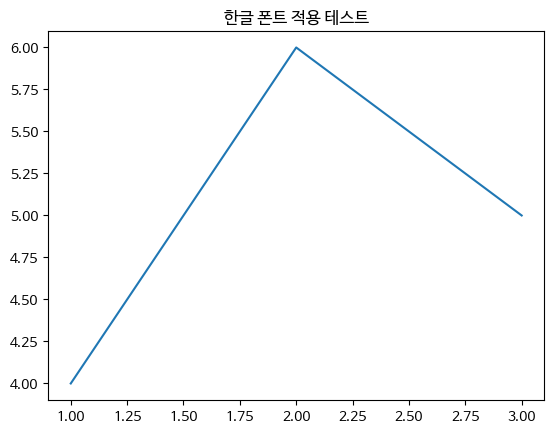

In [29]:
import os
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from collections import defaultdict
from scipy.spatial.distance import cosine
from scipy.stats import entropy

# Konlpy 및 Okt
from konlpy.tag import Okt
okt = Okt()

# Gensim 관련
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel, Word2Vec
from gensim.matutils import cossim
from gensim.models.ldaseqmodel import LdaSeqModel

# 폰트 설정 (Colab)
import matplotlib.font_manager as fm
import matplotlib.cm as cm
import matplotlib.colors as colors

font_path = (r"C:\Users\wooji\Desktop\DTM_statement per actor\NanumBarunGothic.ttf")  # Colab에 설치된 나눔 폰트 경로
fm.fontManager.addfont(font_path)
mpl.rcParams['font.family'] = 'NanumBarunGothic'
mpl.rcParams['axes.unicode_minus'] = False

# 테스트
plt.title("한글 폰트 적용 테스트")
plt.plot([1,2,3],[4,6,5])
plt.show()


In [30]:
##############################################################################
# 1) 데이터 로드 및 기본 전처리
##############################################################################
FILE_PATH = (r"C:\Users\wooji\Desktop\DTM_statement per actor\statement per actor_statement only.xlsx")  # 실제 파일 경로로 수정하세요.
df = pd.read_excel(FILE_PATH)

# 바뀐 부분: 'statement'가 있는지 확인
if ("year" not in df.columns) or ("statement" not in df.columns):
    raise ValueError("엑셀에 'year' 또는 'statement' 컬럼이 없습니다. 확인해주세요.")

# 결측 제거, 연도 컬럼 정리
df.dropna(subset=["statement"], inplace=True)
df["year"] = df["year"].astype(int)
df.sort_values(by="year", inplace=True)
df.reset_index(drop=True, inplace=True)

# 이 때, 여러분이 필요로 하는 다른 컬럼들(ID, text, actor_name 등)은 그대로 둔 채
# 분석에 필요한 부분만 별도로 다루면 됩니다. 예:
print("✅ 데이터 shape:", df.shape)
print(df.head(5))

✅ 데이터 shape: (91402, 9)
      ID  year actor_name actor_affiliation actor_position  \
0  65091  1990        李熺逸             동력자원부             장관   
1  65090  1990        NaN             동력자원부            NaN   
2  65089  1990        NaN             동력자원부            NaN   
3      1  1991        NaN             심사위원회              측   
4      2  1991        趙源奭             기아자동차         재료연구실장   

                                           statement broader_type  \
0  앞으로 에너지정책은 에너지의  장기안정확보에 역점을 두어 현재 60%인 장기계약에 ...   Government   
1  [간접 지적]: 동력자원부는 에너지의 해외의존도 심화와 환경오염 악화에 대처키위해 ...   Government   
2  동력자원부는 금년도 대체에너지 기술개발사업 투자비 90억원중  1차로 60억원을 1...   Government   
3  심사위원회측은 내년 제2회대회부터 자동차의 제작과정에서 발생하는 이산화탄소의 양까지...   Government   
4  기아자동차 재료연구실장 趙源奭씨는 최근에 발표한 「90년대의 자동차 경량화 재료 기...     Economic   

      specific_type country  
0  중앙정부/중앙정부산하 공공기관    대한민국  
1  중앙정부/중앙정부산하 공공기관    대한민국  
2  중앙정부/중앙정부산하 공공기관    대한민국  
3  지방정부/지방정부산하 공공기관      호주  
4               Car    대한민국  


In [31]:
##############################################################################
# 2) 복합어 통합용 딕셔너리 (언더바 변환)
##############################################################################
complex_terms_map = {
    "수소 연료전지": "수소_연료전지",
    "수소연료전지 시스템": "수소연료전지_시스템",
    "연료전지 시스템": "연료전지_시스템",
    "수소 충전소": "수소_충전소",
    "수소차 충전소": "수소차_충전소",
    "전기 수소차": "전기_수소차",
    "전기차 수소차": "전기차_수소차",
    "수소 전기차": "수소_전기차",
    "수소경제 육성": "수소경제_육성",
    "수소경제 활성화": "수소경제_활성화",
    "수소경제 이행": "수소경제_이행",
    "수소 저장": "수소_저장",
    "수소차 시장": "수소차_시장",
    "수소 모빌리티": "수소_모빌리티",
    "수소 밸류체인": "수소_밸류체인",
    "청정 수소": "청정_수소",
    "그린 수소": "그린_수소",
    "수소 산업": "수소_산업",
    "수소 사업": "수소_사업",
    "수소차 보급": "수소차_보급",
    "수소차 충전": "수소차_충전",
    "수소 인프라": "수소_인프라",
    "수소연료전지차 fcev": "수소연료전지차_fcev",
    "연료전지 자동차": "연료전지_자동차",
    "친환경 에너지": "친환경_에너지",
    "신재생 에너지": "신재생_에너지",
    "재생 에너지": "재생_에너지",
    "에너지 전환": "에너지_전환",
    "에너지 저장": "에너지_저장",
    "에너지저장장치 ess": "에너지저장장치_ess",
    "에너지 효율": "에너지_효율",
    "에너지 효율을": "에너지_효율",
    "에너지 효율이": "에너지_효율",
    "에너지 안보": "에너지_안보",
    "에너지 절감": "에너지_절감",
    "미래 에너지": "미래_에너지",
    "전기차 배터리": "전기차_배터리",
    "스마트 그리드": "스마트_그리드",
    "전기차 ev": "전기차_ev",
    "미래 모빌리티": "미래_모빌리티",
    "온실가스 감축": "온실가스_감축",
    "온실가스 배출": "온실가스_배출",
    "온실가스 배출량": "온실가스_배출량",
    "탄소 포집": "탄소_포집",
    "이산화탄소 포집": "이산화탄소_포집",
    "탄소 배출": "탄소_배출",
    "탄소 중립": "탄소_중립",
    "저탄소 녹색성장": "저탄소_녹색성장",
    "기후변화 대응": "기후변화_대응",
    "충전소 구축": "충전소_구축",
    "충전 인프라": "충전_인프라",
    "생산 저장": "생산_저장",
    "포집 저장": "포집_저장",
    "포집 활용": "포집_활용",
    "연료전지 발전소": "연료전지_발전소",
    "연료전지 발전": "연료전지_발전",
    "연료전지 스택": "연료전지_스택",
    "연료전지 sofc": "연료전지_sofc",
    "연료전지 발전사업": "연료전지_발전",
    "플러그인 하이브리드": "플러그인_하이브리드",
    "하이브리드 자동차": "하이브리드_자동차",
    "수소 하이브리드": "수소_하이브리드",
    "소형 suv": "소형_suv",
    "전기차 충전": "전기차_충전",
    "미래형 자동차": "미래형_자동차",
    "미래형 모빌리티": "미래형_모빌리티",
    "차세대 친환경": "차세대_친환경",
    "차세대 에너지": "차세대_에너지",
    "차세대 수소전기차": "차세대_수소전기차",
    "수소연료전지 시스템을": "수소연료전지_시스템",
    "글로벌 에너지": "글로벌_에너지",
    "글로벌 시장": "글로벌_시장",
    "세계 시장": "세계_시장",
    "산업 생태계": "산업_생태계",
    "신성장 동력": "신성장_동력",
    "산업 육성": "산업_육성",
    "산업 육성을": "산업_육성",
    "경제 활성화": "경제_활성화",
    "미래 먹거리": "미래_먹거리",
    "부품 소재": "부품_소재",
    "생산 공급": "생산_공급",
    "공동 개발": "공동_개발",
    "에너지 산업": "에너지_산업",
    "수소 생산": "수소_생산",
    "태양광 풍력": "태양광_풍력",
    "현대 기아차": "현대_기아차",
    "저장 운송": "저장_운송",
    "수소 암모니아": "수소_암모니아",
    "지속 가능한": "지속_가능한",
    "h2 meet": "h2_meet",
    "수소전기차 넥쏘": "수소전기차_넥쏘",
    "고체산화물 연료전지": "고체산화물_연료전지",
    "수소 혼소": "수소_혼소",
    "수소 공급": "수소_공급",
    "풍력 연료전지": "풍력_연료전지",
    "풍력 태양광": "풍력_태양광",
    "메르세데스 벤츠": "메르세데스_벤츠",
    "이산화탄소 배출량을": "이산화탄소_배출량",
    "생태계 조성": "생태계_조성",
    "핵심 기술": "핵심_기술",
    "미래 성장": "미래_성장",
    "수소 사회": "수소_사회",
    "부품 장비": "부품_장비",
    "수소 상용차": "수소_상용차",
    "액화수소 플랜트": "액화수소_플랜트",
    "국내 완성차": "국내_완성차",
    "글로벌 완성차": "글로벌_완성차",
    "그린 수소": "그린_수소",
    "블루 수소": "블루_수소",
    "그레이 수소": "그레이_수소",
    "방사 물질": "방사_물질",
    "연료 전지": "연료_전지",
    "현대차 그룹": "현대차_그룹",
    "기아차 그룹": "기아차_그룹",
    "현대 기아차 그룹": "현대_기아차_그룹",
    "액화 수소": "액화_수소",
    "전기자동차": "전기_자동차",
    "녹색 수소": "녹색_수소",
    "청정 수소": "청정_수소",
    "쏘나타 하이브리드": "쏘나타_하이브리드",
    "스마트 그리드": "스마트_그리드",
    "하이브리드 차량": "하이브리드_차량",
    "연료전지 분야": "연료전지_분야",
    "생태계 구축": "생태계_구축",
    "온실가스 배출을": "온실가스_배출",
    "재생 에너지": "재생_에너지",
    "수소연료전지": "수소_연료_전지"
}

##############################################################################
# 3) 전처리 함수 (문자열 치환)
##############################################################################
def preprocess_text(text):
    for pattern, merged in complex_terms_map.items():
        text = text.replace(pattern, merged)
    return text

df["statement"] = df["statement"].apply(preprocess_text)

##############################################################################
# 4) Okt 객체는 이미 생성됨 (위에서 "okt = Okt()" 실행)
##############################################################################

##############################################################################
# 5) 불용어 사전 (예시)
##############################################################################
stopwords = {
    "하다","되다","있다","그렇다","위해","통해","제공","받다","제시",
    "인하다","한다","된다","오다","지금","수준","지난","돼다","보다","늘다",
    "없다","수소","분석","분야","않다","대한","이다","대다","있다","말했다",
    "밝혔다","이번","머니투데이","저작권자","파이낸셜뉴스","무단전재",
    "copyright","전자신문","디지털뉴스","newsis","donga","com","or","kr","fnnews",
    "mk","에너지데일리","에너지데일리다른기사","뉴스1코리아","news","매일경제",
    "mk","조남준","네이버","메인","또한","위한","mt","edaily","copyrights",
    "헤럴드경제","이데일리","www","kona","heraldbiz","채널","구독","다하겠다",
    "디지털뉴스이용규칙","한국온라인신문협회","한편","디지털타임스","munhwa",
    "kmib","it","포털","etnews","사진","따라","yna","변국영",
    "아니다","때문","같다","시키다","일본","미국","우리","발생","입다","두다","현재","주다","밝히다","지다",
    "오전","메다","띄다","화하다","갖추다","정도","나오다","대해","후끈","맞다","두다","추다",
    "서다","구간","기자","대비","주년","쉬다","세다","걸리다","아끼다","드러내다","타다","선보이다","하니",
    "가운데","달린다","가하다","나타내다","오늘","따르다","차갑다", "뜨다", "만들다","중인","들다", "뉴스",
    "개다","감다","되어다","거두다","가칭","보기","아침","기사","해주다","잦다","가다","넘어가다","살펴보다","km","일으키다"
}

##############################################################################
# 6) 형태소 분석 (토큰화)
##############################################################################
def tokenizer(doc):
    allowed_pos = ["Noun", "Adjective", "Verb", "Alpha"]
    tokens = []
    for token, pos in okt.pos(doc, stem=True, norm=True):
        if pos in allowed_pos and len(token) > 1 and (token not in stopwords):
            tokens.append(token)
    return tokens

df["tokens"] = df["statement"].apply(tokenizer)

print("\n[1단계] 전처리 + 형태소 분석 결과 예시")
print(df[["year","tokens"]].head(10))

##############################################################################
# 불용어 재제거 (후처리)
##############################################################################
def remove_stopwords_after(tokens, remove_list):
    return [t for t in tokens if t not in remove_list]

df["tokens"] = df["tokens"].apply(lambda x: remove_stopwords_after(x, stopwords))

##############################################################################
# 7) 후처리: 연속된 두 토큰을 merge_map에 따라 병합하기
##############################################################################
merge_map = {
    ("수소", "연료전지"): "수소_연료전지",
    ("수소연료전지", "시스템"): "수소연료전지_시스템",
    ("연료전지", "시스템"): "연료전지_시스템",
    ("수소", "충전소"): "수소_충전소",
    ("수소차", "충전소"): "수소차_충전소",
    ("전기", "수소차"): "전기_수소차",
    ("전기차", "수소차"): "전기차_수소차",
    ("수소", "전기차"): "수소_전기차",
    ("수소경제", "육성"): "수소경제_육성",
    ("수소경제", "활성화"): "수소경제_활성화",
    ("수소경제", "이행"): "수소경제_이행",
    ("수소", "저장"): "수소_저장",
    ("수소차", "시장"): "수소차_시장",
    ("수소", "모빌리티"): "수소_모빌리티",
    ("수소", "밸류체인"): "수소_밸류체인",
    ("청정", "수소"): "청정_수소",
    ("그린", "수소"): "그린_수소",
    ("수소", "산업"): "수소_산업",
    ("수소", "사업"): "수소_사업",
    ("수소차", "보급"): "수소차_보급",
    ("수소차", "충전"): "수소차_충전",
    ("수소차", "충전소"): "수소차_충전소",
    ("수소", "인프라"): "수소_인프라",
    ("수소연료전지차", "fcev"): "수소연료전지차_fcev",
    ("연료전지", "자동차"): "연료전지_자동차",
    ("친환경", "에너지"): "친환경_에너지",
    ("신재생", "에너지"): "신재생_에너지",
    ("재생", "에너지"): "재생_에너지",
    ("에너지", "전환"): "에너지_전환",
    ("에너지", "저장"): "에너지_저장",
    ("에너지저장장치", "ess"): "에너지저장장치_ess",
    ("에너지", "효율"): "에너지_효율",
    ("에너지", "안보"): "에너지_안보",
    ("에너지", "절감"): "에너지_절감",
    ("미래", "에너지"): "미래_에너지",
    ("전기차", "배터리"): "전기차_배터리",
    ("스마트", "그리드"): "스마트_그리드",
    ("전기차", "ev"): "전기차_ev",
    ("미래", "모빌리티"): "미래_모빌리티",
    ("온실가스", "감축"): "온실가스_감축",
    ("온실가스", "배출"): "온실가스_배출",
    ("온실가스", "배출량"): "온실가스_배출량",
    ("탄소", "포집"): "탄소_포집",
    ("이산화탄소", "포집"): "이산화탄소_포집",
    ("탄소", "배출"): "탄소_배출",
    ("탄소", "중립"): "탄소_중립",
    ("저탄소", "녹색성장"): "저탄소_녹색성장",
    ("기후변화", "대응"): "기후변화_대응",
    ("충전소", "구축"): "충전소_구축",
    ("충전", "인프라"): "충전_인프라",
    ("생산", "저장"): "생산_저장",
    ("포집", "저장"): "포집_저장",
    ("포집", "활용"): "포집_활용",
    ("연료전지", "발전소"): "연료전지_발전소",
    ("연료전지", "발전"): "연료전지_발전",
    ("연료전지", "스택"): "연료전지_스택",
    ("연료전지", "sofc"): "연료전지_sofc",
    ("플러그인", "하이브리드"): "플러그인_하이브리드",
    ("하이브리드", "자동차"): "하이브리드_자동차",
    ("수소", "하이브리드"): "수소_하이브리드",
    ("소형", "suv"): "소형_suv",
    ("전기차", "충전"): "전기차_충전",
    ("미래형", "자동차"): "미래형_자동차",
    ("미래형", "모빌리티"): "미래형_모빌리티",
    ("차세대", "친환경"): "차세대_친환경",
    ("차세대", "에너지"): "차세대_에너지",
    ("차세대", "수소전기차"): "차세대_수소전기차",
    ("수소연료전지", "시스템"): "수소연료전지_시스템",
    ("글로벌", "에너지"): "글로벌_에너지",
    ("글로벌", "시장"): "글로벌_시장",
    ("세계", "시장"): "세계_시장",
    ("산업", "생태계"): "산업_생태계",
    ("신성장", "동력"): "신성장_동력",
    ("산업", "육성"): "산업_육성",
    ("경제", "활성화"): "경제_활성화",
    ("미래", "먹거리"): "미래_먹거리",
    ("부품", "소재"): "부품_소재",
    ("생산", "공급"): "생산_공급",
    ("공동", "개발"): "공동_개발",
    ("에너지", "산업"): "에너지_산업",
    ("수소", "생산"): "수소_생산",
    ("태양광", "풍력"): "태양광_풍력",
    ("현대", "기아차"): "현대_기아차",
    ("저장", "운송"): "저장_운송",
    ("수소", "암모니아"): "수소_암모니아",
    ("지속", "가능한"): "지속_가능한",
    ("h2", "meet"): "h2_meet",
    ("수소전기차", "넥쏘"): "수소전기차_넥쏘",
    ("고체산화물", "연료전지"): "고체산화물_연료전지",
    ("수소", "혼소"): "수소_혼소",
    ("수소", "공급"): "수소_공급",
    ("풍력", "연료전지"): "풍력_연료전지",
    ("풍력", "태양광"): "풍력_태양광",
    ("메르세데스", "벤츠"): "메르세데스_벤츠",
    ("이산화탄소", "배출량"): "이산화탄소_배출량",
    ("생태계", "조성"): "생태계_조성",
    ("핵심", "기술"): "핵심_기술",
    ("미래", "성장"): "미래_성장",
    ("수소", "사회"): "수소_사회",
    ("부품", "장비"): "부품_장비",
    ("수소", "상용차"): "수소_상용차",
    ("액화수소", "플랜트"): "액화수소_플랜트",
    ("국내", "완성차"): "국내_완성차",
    ("글로벌", "완성차"): "글로벌_완성차",
    ("그린", "수소"): "그린_수소",
    ("블루", "수소"): "블루_수소",
    ("그레이", "수소"): "그레이_수소",
    ("방사", "물질"): "방사_물질",
    ("연료", "전지"): "연료_전지",
    ("현대차", "그룹"): "현대차_그룹",
    ("기아차", "그룹"): "기아차_그룹",
    ("액화", "수소"): "액화_수소",
    ("전기", "자동차"): "전기_자동차",
    ("녹색", "수소"): "녹색_수소",
    ("청정", "수소"): "청정_수소",
    ("쏘나타", "하이브리드"): "쏘나타_하이브리드",
    ("하이브리드", "차량"): "하이브리드_차량",
    ("연료전지", "분야"): "연료전지_분야",
    ("생태계", "구축"): "생태계_구축",
    ("온실가스", "배출"): "온실가스_배출",
    ("재생", "에너지"): "재생_에너지",
    ("수소", "연료"): "수소_연료",
    ("대기", "오염"): "대기_오염",
    ("가스", "안전"): "가스안전",
    ("가스안전", "공사"): "가스안전공사",
    ("충북", "혁신"): "충북혁신",
    ("충북혁신", "도시"): "충북혁신도시",
    ("충북", "혁신도시"): "충북혁신도시",
    ("SK", "건설"): "SK건설",
    ("SK", "에코"): "SK에코",
    ("SK에코", "플랜트"): "SK에코플랜트",
    ("동서", "발전"): "동서발전",
    ("한화", "에어로"): "한화에어로",
    ("한화에어로", "스페이스"): "한화에어로스페이스",
    ("LG", "화학"): "LG화학",
    ("모토로라", "코리아"): "모토로라코리아",
    ("수소", "기술"): "수소기술",
    ("CJ", "대한"): "CJ대한",
    ("대한", "통운"): "대한통운",
    ("CJ대한", "통운"): "CJ대한통운",
    ("CJ", "대한통운"): "CJ대한통운",
    ("경남", "에너지"): "경남에너지",
    ("SK", "에너지"): "SK에너지",
    ("LG", "전자"): "LG전자",
    ("귀뚜라미", "그룹"): "귀뚜라미그룹",
    ("GS", "칼텍스"): "GS칼텍스",
    ("가스", "연맹"): "가스연맹",
    ("녹색", "기술"): "녹색기술",
    ("한국", "전력"): "한국전력",
    ("두산", "모빌리티"): "두산모빌리티",
    ("GS", "건설"): "GS건설",
    ("삼성", "SDI"): "삼성SDI",
    ("삼성", "전자"): "삼성전자",
    ("삼성", "중공업"): "삼성중공업",
    ("친환경", "자동차"): "친환경자동차",
    ("한국", "가스"): "한국가스",
    ("한국가스", "공사"): "한국가스공사",
    ("현대", "오일"): "현대오일",
    ("현대오일", "뱅크"): "현대오일뱅크",
    ("효성", "중공업"): "효성중공업",
    ("두산", "퓨얼셀"): "두산퓨얼셀",
    ("SK", "디앤디"): "SK디앤디",
    ("롯데", "건설"): "롯데건설",
    ("동아", "퓨얼셀"): "동아퓨얼셀",
    ("청정", "수소"): "청정수소"
}

def merge_tokens(tokens):
    merged = []
    skip_next = False
    for i in range(len(tokens)):
        if skip_next:
            skip_next = False
            continue
        if i < len(tokens) - 1:
            pair = (tokens[i], tokens[i+1])
            if pair in merge_map:
                merged.append(merge_map[pair])
                skip_next = True
                continue
        merged.append(tokens[i])
    return merged

df["tokens"] = df["tokens"].apply(merge_tokens)
print("\n[2단계] 후처리(토큰 재결합) 결과 예시")
print(df[["year","tokens"]].head(10))

##############################################################################
# 8) Gensim Dictionary & Corpus 생성
##############################################################################
dictionary = Dictionary(df["tokens"])
dictionary.filter_extremes(no_below=3, no_above=0.7)
corpus = [dictionary.doc2bow(t) for t in df["tokens"]]

print("\n✅ dictionary, corpus 생성 완료")
print("사전에 등록된 단어 수:", len(dictionary))

##############################################################################
# 9) 최종 저장 (pickle 및 엑셀)
##############################################################################
df.to_pickle("df_documents_tokens.pkl")
with open("dictionary.pkl","wb") as f:
    pickle.dump(dictionary, f)
with open("corpus.pkl","wb") as f:
    pickle.dump(corpus, f)

print("\n✅ 전처리 + 형태소 분석 + 토큰 재결합 + Dictionary/Corpus 생성 완료!")
print("→ df_documents_tokens.pkl, dictionary.pkl, corpus.pkl 저장됨.")

output_excel = "preprocessed_data.xlsx"
df.to_excel(output_excel, index=False)
print(f"✅ 엑셀 '{output_excel}' 저장 완료")

try:
    from google.colab import files
    files.download(output_excel)
    print("✅ 자동 다운로드 완료 (Colab 환경)")
except ImportError:
    print("⚠ 로컬 환경이면 파일만 저장됩니다.")



[1단계] 전처리 + 형태소 분석 결과 예시
   year                                             tokens
0  1990  [에너지정책, 에너지, 장기, 안정, 확보, 역점, 장기, 계약, 의하다, 도입, ...
1  1990  [간접, 지적, 동력자원부, 에너지, 해외, 의존, 심화, 환경오염, 악화, 처키,...
2  1990  [동력자원부, 금년, 대체에너지, 기술, 개발, 사업, 자비, 차로, 사업, 지원,...
3  1991  [심사, 위원회, 측은, 내년, 자동차, 과정, 이산화탄소, 심사, 고려, 예정, ...
4  1991  [기아, 자동차, 재료, 연구실, 최근, 발표, 자동차, 경량, 재료, 기술, 이란...
5  1991  [연료, 전지, 산업화, 성공하다, 발전소, 효율, 높아지다, 공장, 시설, 축소,...
6  1991  [연료, 전지, 산업화, 성공하다, 효율, 높아지다, 우선, 싸다, 복잡하다, 기계...
7  1991  [경우, 부시, 대통령, 국가, 에너지, 전략, 발표, 에너지, 개발, 통한, 에너...
8  1991  [연료, 전지, 산업화, 성공하다, 발전소, 효율, 높아지다, 공장, 시설, 축소,...
9  1992  [간접, 지적, 한국, 연구소, 올해, 전력, 관련, 핵심, 기술, 개발, 서두르다...

[2단계] 후처리(토큰 재결합) 결과 예시
   year                                             tokens
0  1990  [에너지정책, 에너지, 장기, 안정, 확보, 역점, 장기, 계약, 의하다, 도입, ...
1  1990  [간접, 지적, 동력자원부, 에너지, 해외, 의존, 심화, 환경오염, 악화, 처키,...
2  1990  [동력자원부, 금년, 대체에너지, 기술, 개발, 사업, 자비, 차로, 사업, 지원,...
3  1991  [심사, 위원회, 측은, 내년, 자동차, 과정, 이산화탄소, 심사, 고려, 예정, ...
4  19

[k=10] Coherence=0.4186, Perplex=-7.9762, Exclusivity=0.9720
[k=11] Coherence=0.4564, Perplex=-8.1799, Exclusivity=0.9759
[k=12] Coherence=0.4557, Perplex=-8.5320, Exclusivity=0.9725
[k=13] Coherence=0.4561, Perplex=-9.0693, Exclusivity=0.9754
[k=14] Coherence=0.4317, Perplex=-9.6899, Exclusivity=0.9754
[k=15] Coherence=0.4490, Perplex=-10.2792, Exclusivity=0.9757
[k=16] Coherence=0.4403, Perplex=-10.8404, Exclusivity=0.9781
[k=17] Coherence=0.4467, Perplex=-11.0749, Exclusivity=0.9706
[k=18] Coherence=0.4300, Perplex=-11.4158, Exclusivity=0.9700
[k=19] Coherence=0.4249, Perplex=-11.6015, Exclusivity=0.9737
[k=20] Coherence=0.4155, Perplex=-11.8067, Exclusivity=0.9768
[k=21] Coherence=0.4292, Perplex=-11.9908, Exclusivity=0.9748
[k=22] Coherence=0.4255, Perplex=-12.1828, Exclusivity=0.9689
[k=23] Coherence=0.4173, Perplex=-12.3604, Exclusivity=0.9667
[k=24] Coherence=0.4072, Perplex=-12.5662, Exclusivity=0.9708
[k=25] Coherence=0.3977, Perplex=-12.7710, Exclusivity=0.9728
[k=26] Cohere

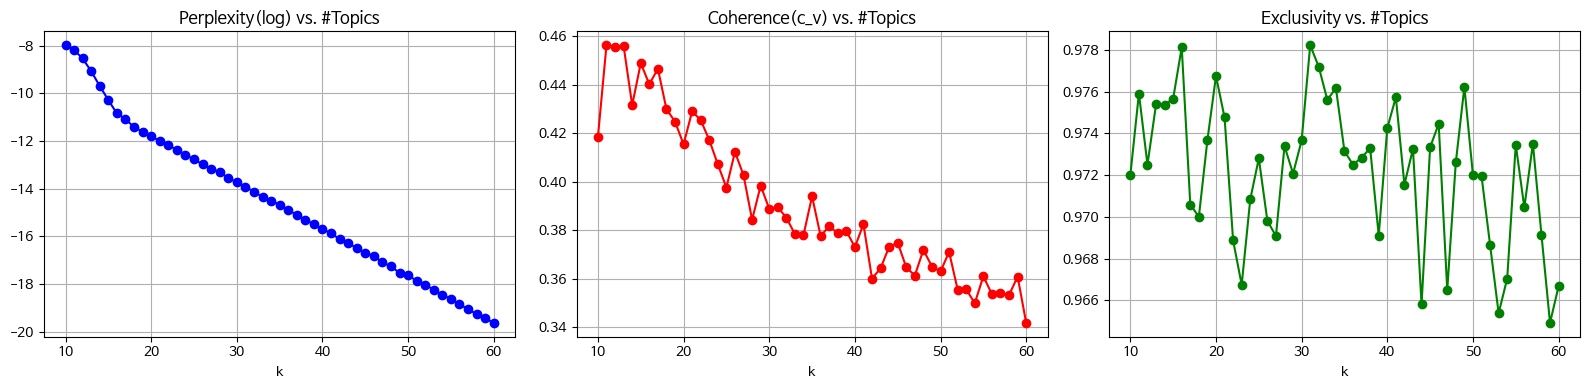


🔹 Coherence 기준 최고 k = 11 (Coherence=0.4564)


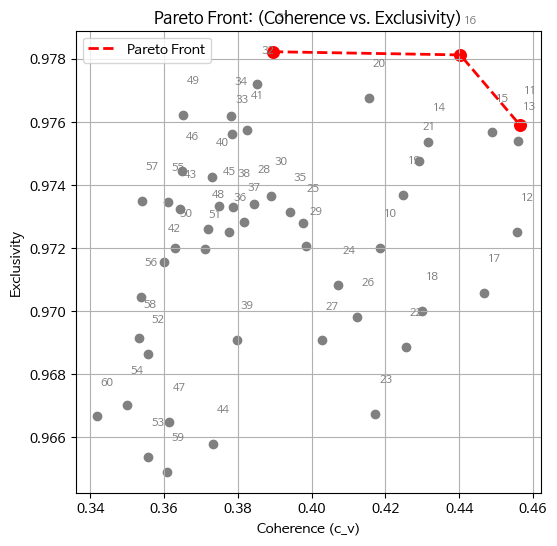


🔸 Pareto front 내 k 후보:
  k=11, coherence=0.4564, exclusivity=0.9759
  k=16, coherence=0.4403, exclusivity=0.9781
  k=31, coherence=0.3895, exclusivity=0.9782

✅ Pareto set 중 (Coherence+Exclusivity) 합이 최대인 k=11, score=1.4323
📌 최종 선택된 k = 11
✅ 최종 선택된 k가 'best_k.pkl'에 저장되었습니다.


In [32]:
##############################################################################
# 10) LDA 평가: Coherence, Perplexity, Exclusivity & Pareto Front
##############################################################################
def compute_exclusivity(model, num_words=20):
    topic_words = []
    for tid in range(model.num_topics):
        tw = [word for word, _ in model.show_topic(tid, topn=num_words)]
        topic_words.append(tw)
    excl_scores = []
    for i, words_i in enumerate(topic_words):
        overlap_counts = []
        for w in words_i:
            overlap_count = sum(w in topic_words[j] for j in range(model.num_topics) if j != i)
            overlap_counts.append(overlap_count)
        avg_overlap = np.mean(overlap_counts)
        excl = 1 - (avg_overlap / num_words)
        excl_scores.append(excl)
    return np.mean(excl_scores)

def find_pareto_front(points):
    pareto = []
    for (xA, yA, kA) in points:
        dominated = False
        for (xB, yB, kB) in points:
            if (xB >= xA and yB >= yA) and ((xB > xA) or (yB > yA)):
                dominated = True
                break
        if not dominated:
            pareto.append((xA, yA, kA))
    return pareto

def show_coherence_exclusivity_with_pareto(df_texts, dictionary, corpus,
                                           k_min=3, k_max=10,
                                           passes=20, iterations=400, chunksize=1000,
                                           random_state=42):
    results = []  # (k, perplex, coherence, exclusivity)
    best_coh = float('-inf')
    best_k_coh = None
    for k in range(k_min, k_max+1):
        lda_model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=k,
            passes=passes,
            iterations=iterations,
            chunksize=chunksize,
            eval_every=0,
            random_state=random_state
        )
        perp = lda_model.log_perplexity(corpus)
        cm_model = CoherenceModel(model=lda_model, texts=df_texts, dictionary=dictionary, coherence='c_v')
        coh = cm_model.get_coherence()
        excl = compute_exclusivity(lda_model)
        results.append((k, perp, coh, excl))
        print(f"[k={k}] Coherence={coh:.4f}, Perplex={perp:.4f}, Exclusivity={excl:.4f}")
        if coh > best_coh:
            best_coh = coh
            best_k_coh = k
    ks = [r[0] for r in results]
    perps = [r[1] for r in results]
    cohes = [r[2] for r in results]
    exclu = [r[3] for r in results]

    plt.figure(figsize=(16,4))
    plt.subplot(1, 3, 1)
    plt.plot(ks, perps, 'b-o')
    plt.title("Perplexity(log) vs. #Topics")
    plt.xlabel("k")
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(ks, cohes, 'r-o')
    plt.title("Coherence(c_v) vs. #Topics")
    plt.xlabel("k")
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(ks, exclu, 'g-o')
    plt.title("Exclusivity vs. #Topics")
    plt.xlabel("k")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"\n🔹 Coherence 기준 최고 k = {best_k_coh} (Coherence={best_coh:.4f})")

    ce_points = [(r[2], r[3], r[0]) for r in results]
    pareto_set = find_pareto_front(ce_points)

    plt.figure(figsize=(6,6))
    for (c_val, e_val, k_val) in ce_points:
        plt.scatter(c_val, e_val, color='gray')
        plt.text(c_val+0.001, e_val+0.001, str(k_val), fontsize=8, color='gray')

    pareto_sorted = sorted(pareto_set, key=lambda x: x[0])
    px = [p[0] for p in pareto_sorted]
    py = [p[1] for p in pareto_sorted]
    plt.plot(px, py, 'r--', lw=2, label="Pareto Front")
    plt.scatter(px, py, color='red', s=70)

    plt.title("Pareto Front: (Coherence vs. Exclusivity)")
    plt.xlabel("Coherence (c_v)")
    plt.ylabel("Exclusivity")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\n🔸 Pareto front 내 k 후보:")
    for (c,e,kval) in pareto_set:
        print(f"  k={kval}, coherence={c:.4f}, exclusivity={e:.4f}")

    best_sum = -999
    best_k_sum = None
    for (c,e,kval) in pareto_set:
        score = c + e
        if score > best_sum:
            best_sum = score
            best_k_sum = kval
    print(f"\n✅ Pareto set 중 (Coherence+Exclusivity) 합이 최대인 k={best_k_sum}, score={best_sum:.4f}")
    return best_k_sum

best_k = show_coherence_exclusivity_with_pareto(
    df_texts=df["tokens"].tolist(),
    dictionary=dictionary,
    corpus=corpus,
    k_min=10,
    k_max=60,
    passes=10,
    iterations=300,
    chunksize=500,
    random_state=42
)
print("📌 최종 선택된 k =", best_k)
with open("best_k.pkl", "wb") as f:
    pickle.dump(best_k, f)
print("✅ 최종 선택된 k가 'best_k.pkl'에 저장되었습니다.")

In [33]:
##############################################################################
# 11) 연도별 LDA 키워드 추출 & Word2Vec 학습
##############################################################################
def get_yearly_lda_keywords(df, dictionary, k, passes=10, iterations=300, topn=10, random_state=42):
    yearly_keywords_map = {}
    unique_years = sorted(df["year"].unique())
    for y in unique_years:
        subset = df[df["year"] == y]
        if len(subset) < 3:
            print(f"⚠ {y}년도 문서가 3개 미만이므로 스킵")
            continue
        sub_dict = Dictionary(subset["tokens"])
        sub_dict.filter_extremes(no_below=2, no_above=0.7)
        sub_corpus = [sub_dict.doc2bow(t) for t in subset["tokens"]]
        lda_model = LdaModel(
            corpus=sub_corpus,
            id2word=sub_dict,
            num_topics=k,
            passes=passes,
            iterations=iterations,
            random_state=random_state
        )
        all_top_words = set()
        for topic_id in range(k):
            for w, _ in lda_model.show_topic(topic_id, topn=topn):
                all_top_words.add(w)
        yearly_keywords_map[y] = list(all_top_words)
    return yearly_keywords_map

yearly_keywords = get_yearly_lda_keywords(df, dictionary, k=best_k)
print(yearly_keywords)
with open("lda_keywords_by_year.pkl","wb") as f:
    pickle.dump(yearly_keywords, f)
print("\n✅ 연도별 상위 키워드가 'lda_keywords_by_year.pkl'로 저장되었습니다.")


# Word2Vec 모델 학습 (연도별)
yearly_docs = {}
for year in sorted(df["year"].unique()):
    docs = df[df["year"] == year]["tokens"].tolist()
    yearly_docs[year] = docs

word2vec_models = {}
for year, sentences in yearly_docs.items():
    model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
    word2vec_models[year] = model

with open("word2vec_models.pkl", "wb") as f:
    pickle.dump(word2vec_models, f)
print("\n✅ 연도별 Word2Vec 학습 완료!")

⚠ 91116년도 문서가 3개 미만이므로 스킵
{1990: ['의존', '대상', '적극', '기업', '지원', '금년', '방침', '에너지', '공모', '민간', '기금', '석유', '동력자원부', '동자부', '확보', '올해', '연료'], 1991: ['시설', '적극', '효과', '감안', '발표', '추진', '공장', '발전소', '연구', '국내', '개선', '기술', '자동차', '국가', '기울이다', '문제', '경우', '진행', '개발', '연료_전지', '공해'], 1992: ['협력', '전기_자동차', '지속', '실용', '다음', '장기', '체계', '국제', '에너지_효율', '성공하다', '새롭다', '목표', '메탄올', '사업', '발표', '지적', '추진', '화석연료', '프레온', '발전소', '절약', '연구', '발전', '관계자', '국내', '환경', '투자', '세계', '예정', '방안', '시험', '첨단', '한국', '비롯', '사용', '마련', '효율', '간접', '줄이다', '관련', '전략', '국가', '공급', '과제', '선진', '독일', '회사', '수립', '기여', '정상회담', '최근', '에너지', '전력', '개발', '확보', '연료_전지', '연구개발', '건설'], 1993: ['협력', '바이오', '연구개발', '기후변화', '제품', '탄산염', '부처', 'kW', '운영', '지구', '생산', '억제', '제도', '대형', '지적', '추진', '계획', '확대', '연구', '관계자', '발전', '나가다', '투자', '액화', '세계', '시스템', '정부', '이탈리아', '다른', '방안', '수송', '연료', 'KIST', '한국', '사용', '전기', '간접', '줄이다', '기술', '선진국', '올해', '가능하다', '태양광', '사이', '소비', '지원', '살리다', '도입', '에너지', '최근', '개발', '연

In [34]:
##############################################################################
# 12) Word2Vec 기반 연도 병합 로직 (LDA 키워드 활용)
##############################################################################
with open("lda_keywords_by_year.pkl", "rb") as f:
    lda_keywords_by_year = pickle.load(f)

def get_word_similarity(word, year1, year2):
    if (word in word2vec_models[year1].wv) and (word in word2vec_models[year2].wv):
        vec1 = word2vec_models[year1].wv[word]
        vec2 = word2vec_models[year2].wv[word]
        return 1 - cosine(vec1, vec2)
    return None

min_docs = 3
topic_change_threshold = 0.7
time_slice_dynamic = []
merged_years = []
unique_years = sorted(df["year"].unique())
current_year = None
current_count = 0

for i in range(len(unique_years) - 1):
    y1 = unique_years[i]
    y2 = unique_years[i + 1]
    lda_keywords = list(set(lda_keywords_by_year.get(y1, [])) & set(lda_keywords_by_year.get(y2, [])))
    if not lda_keywords:
        lda_keywords = ["발전", "기업", "생산", "지원", "전지", "자동차", "전기차", "시장", "경제", "공장", "탄소"]
    word_change = np.mean([get_word_similarity(w, y1, y2) or 0 for w in lda_keywords])
    if current_year is None:
        current_year = y1
        current_count = len(df[df["year"]==y1])
    if word_change > topic_change_threshold or current_count < min_docs:
        current_count += len(df[df["year"]==y2])
    else:
        time_slice_dynamic.append(current_count)
        merged_years.append(f"{current_year}-{y1}" if current_year != y1 else str(current_year))
        current_year = y2
        current_count = len(df[df["year"]==y2])
time_slice_dynamic.append(current_count)
merged_years.append(str(current_year))

with open("time_slice_dynamic.pkl", "wb") as f:
    pickle.dump(time_slice_dynamic, f)
with open("merged_years.pkl", "wb") as f:
    pickle.dump(merged_years, f)

print("\n✅ 연도 병합(동적 구간) 완료!")
print("time_slice_dynamic:", time_slice_dynamic)
print("merged_years:", merged_years)


✅ 연도 병합(동적 구간) 완료!
time_slice_dynamic: [3, 6, 12, 10, 8, 8, 16, 10, 5, 24, 125, 158, 172, 32161, 6100, 7536, 7249, 9585, 9513, 9542, 9014, 143, 2]
merged_years: ['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003-2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '91116']


All years: [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]

[연도별 토픽 변화 예시]--------------------------------
1990 → 1991 CosSim=0.0563
1991 → 1992 CosSim=0.2292
1992 → 1993 CosSim=0.3187
1993 → 1994 CosSim=0.2462
1994 → 1995 CosSim=0.3503
1995 → 1996 CosSim=0.3582
1996 → 1997 CosSim=0.2681
1997 → 1998 CosSim=0.2010
1998 → 1999 CosSim=0.2255
1999 → 2000 CosSim=0.2781
2000 → 2001 CosSim=0.3709
2001 → 2002 CosSim=0.3539
2002 → 2003 CosSim=0.4526
2003 → 2004 CosSim=0.4555
2004 → 2005 CosSim=0.4954
2005 → 2006 CosSim=0.5879
2006 → 2007 CosSim=0.6266
2007 → 2008 CosSim=0.4587
2008 → 2009 CosSim=0.5085
2009 → 2010 CosSim=0.4779
2010 → 2011 CosSim=0.4819
2011 → 2012 CosSim=0.5963
2012 → 2013 CosSim=0.5494
2013 → 2014 CosSim=0.4917
2014 → 2015 CosSim=0.5655
2015 → 2016 CosSim=0.5945
2016 → 2017 CosSim=0.6154
2017 → 2018 CosSim=0.5

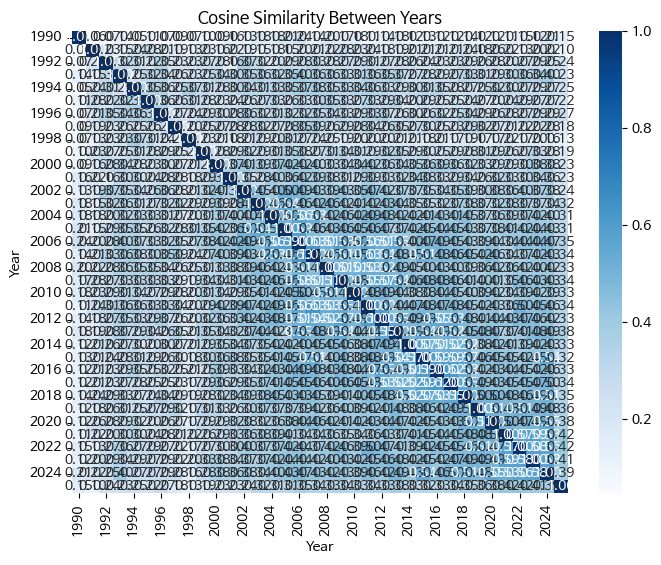

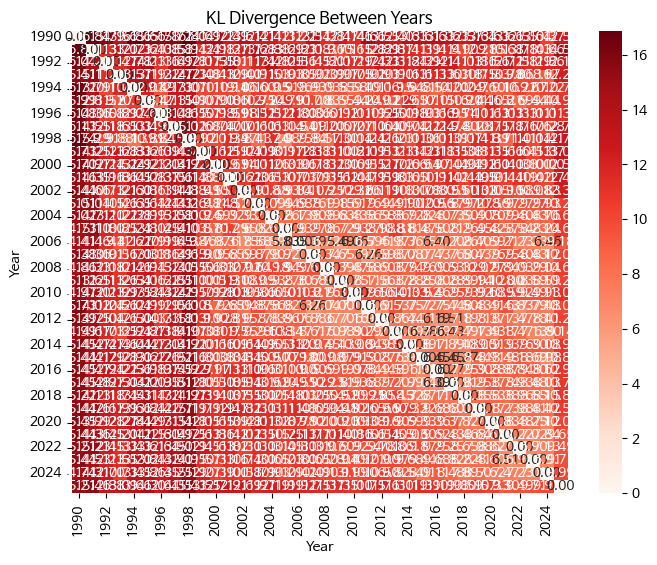

⚠ Colab 환경이 아닙니다. 파일은 로컬에 저장되었습니다.


In [35]:
##############################################################################
# 13) 연도별 토픽 변화 분석 (Cosine Similarity & KL Divergence)
##############################################################################
all_years = sorted(list(yearly_keywords.keys()))
print("All years:", all_years)
year_topic_vectors = {}
for y in all_years:
    word_list = yearly_keywords[y]
    vec = np.zeros(len(dictionary))
    for w in word_list:
        if w in dictionary.token2id:
            vec[dictionary.token2id[w]] += 1
    if np.sum(vec) > 0:
        vec = vec / np.sum(vec)
    year_topic_vectors[y] = vec

if len(all_years) == 0:
    print("⚠ 'yearly_keywords'에 데이터가 없습니다. 연도별 데이터 필터링 조건을 확인하세요.")
else:
    year_similarities = []
    year_kl_divergences = []
    for i in range(len(all_years)-1):
        y1, y2 = all_years[i], all_years[i+1]
        v1, v2 = year_topic_vectors[y1], year_topic_vectors[y2]
        cos_sim = cossim(dict(enumerate(v1)), dict(enumerate(v2)))
        kl_div = entropy(v1 + 1e-9, v2 + 1e-9)
        year_similarities.append((y1, y2, cos_sim))
        year_kl_divergences.append((y1, y2, kl_div))

    df_similarity = pd.DataFrame(year_similarities, columns=["Year1", "Year2", "Cosine_Sim"])
    df_kl = pd.DataFrame(year_kl_divergences, columns=["Year1", "Year2", "KL_Div"])

    df_similarity.to_excel("Year_Topic_CosSim.xlsx", index=False)
    df_kl.to_excel("Year_Topic_KLDiv.xlsx", index=False)

    print("\n[연도별 토픽 변화 예시]--------------------------------")
    for (y1, y2, s) in year_similarities:
        print(f"{y1} → {y2} CosSim={s:.4f}")
    for (y1, y2, kl) in year_kl_divergences:
        print(f"{y1} → {y2} KLDiv={kl:.4f}")

    cos_matrix = pd.DataFrame(np.zeros((len(all_years), len(all_years))),
                              index=all_years, columns=all_years)
    for i, y1 in enumerate(all_years):
        v1 = year_topic_vectors[y1]
        for j, y2 in enumerate(all_years):
            v2 = year_topic_vectors[y2]
            if np.sum(v1) == 0 or np.sum(v2) == 0:
                cos_val = 0.0
            else:
                cos_val = cossim(dict(enumerate(v1)), dict(enumerate(v2)))
            cos_matrix.loc[y1, y2] = cos_val
    plt.figure(figsize=(8,6))
    sns.heatmap(cos_matrix, annot=True, cmap="Blues", fmt=".2f")
    plt.title("Cosine Similarity Between Years")
    plt.xlabel("Year")
    plt.ylabel("Year")
    plt.show()

    kl_matrix = pd.DataFrame(np.zeros((len(all_years), len(all_years))),
                             index=all_years, columns=all_years)
    for i, y1 in enumerate(all_years):
        v1 = year_topic_vectors[y1]
        for j, y2 in enumerate(all_years):
            v2 = year_topic_vectors[y2]
            kl_val = entropy(v1 + 1e-9, v2 + 1e-9)
            kl_matrix.loc[y1, y2] = kl_val
    plt.figure(figsize=(8,6))
    sns.heatmap(kl_matrix, annot=True, cmap="Reds", fmt=".2f")
    plt.title("KL Divergence Between Years")
    plt.xlabel("Year")
    plt.ylabel("Year")
    plt.show()

try:
    from google.colab import files
    files.download("Year_Topic_CosSim.xlsx")
    files.download("Year_Topic_KLDiv.xlsx")
    print("✅ 파일이 다운로드되었습니다.")
except ImportError:
    print("⚠ Colab 환경이 아닙니다. 파일은 로컬에 저장되었습니다.")


In [36]:
# ---------------------------------------------------------------------------
# (0) 공통 import
# ---------------------------------------------------------------------------
import numpy as np
import pandas as pd
import pickle
from gensim.models.ldaseqmodel import LdaSeqModel
import matplotlib.pyplot as plt   # 필요 시 사용

# ---------------------------------------------------------------------------
# (1) 필요한 파일 불러오기
# ---------------------------------------------------------------------------
df = pd.read_pickle("df_documents_tokens.pkl")          # 전처리된 df
with open("time_slice_dynamic.pkl", "rb") as f:
    time_slice_dynamic = pickle.load(f)
with open("merged_years.pkl", "rb") as f:
    merged_years = pickle.load(f)
with open("corpus.pkl", "rb") as f:
    corpus = pickle.load(f)
with open("dictionary.pkl", "rb") as f:
    dictionary = pickle.load(f)
with open("best_k.pkl", "rb") as f:
    best_k = pickle.load(f)

print("📂 파일 로드 완료")

# ---------------------------------------------------------------------------
# (2) DTM(LdaSeqModel) 학습
# ---------------------------------------------------------------------------
ldaseq = LdaSeqModel(
    corpus=corpus,
    id2word=dictionary,
    time_slice=time_slice_dynamic,
    num_topics=best_k,
    random_state=42
)

print("\n✅ LdaSeqModel 학습 완료")
print("  • time_slice_dynamic =", time_slice_dynamic, "(합 =", sum(time_slice_dynamic), ")")
print("  • merged_years       =", merged_years)
print("  • best_k             =", best_k)

ldaseq.save("my_dtmmodel")
print("✅ 모델 저장 → 'my_dtmmodel'")

📂 파일 로드 완료


c:\Users\wooji\anaconda3\envs\pypsa-earth\lib\site-packages\gensim\models\ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in scalar divide
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
c:\Users\wooji\anaconda3\envs\pypsa-earth\lib\site-packages\gensim\models\ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in scalar divide
  convergence = np.fabs((bound - old_bound) / old_bound)
c:\Users\wooji\anaconda3\envs\pypsa-earth\lib\site-packages\gensim\models\ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in scalar divide
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
c:\Users\wooji\anaconda3\envs\pypsa-earth\lib\site-packages\gensim\models\ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in scalar divide
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
c:\Users\wooji\anaconda3\envs\pypsa-earth\lib\site-packages\gensim\models\ldaseqmodel.py:1480: RuntimeWarning: invalid value encount


✅ LdaSeqModel 학습 완료
  • time_slice_dynamic = [3, 6, 12, 10, 8, 8, 16, 10, 5, 24, 125, 158, 172, 32161, 6100, 7536, 7249, 9585, 9513, 9542, 9014, 143, 2] (합 = 91402 )
  • merged_years       = ['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003-2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '91116']
  • best_k             = 11
✅ 모델 저장 → 'my_dtmmodel'


In [37]:
# ---------------------------------------------------------------------------
# (3) (1) 시점별 토픽 대표단어 추출 → DTM_Topic_Words.xlsx
# ---------------------------------------------------------------------------
topic_word_detail = []

for topic_id in range(best_k):
    # topic_times: 각 시점별 (단어, 가중치) 리스트
    topic_times = ldaseq.print_topic_times(topic_id)
    for t_idx, word_weight_list in enumerate(topic_times):
        the_year = merged_years[t_idx] if t_idx < len(merged_years) else f"TimeIndex_{t_idx}"

        # 상위 20개 단어 저장
        for (word, weight) in word_weight_list[:20]:
            topic_word_detail.append({
                "Topic": topic_id,
                "TimeIndex": t_idx,
                "Year": the_year,
                "Word": word,
                "Weight": weight
            })

df_topic_words = pd.DataFrame(topic_word_detail)
df_topic_words.to_excel("DTM_Topic_Words.xlsx", index=False)
print("✅ (1) 시점별 토픽 단어/가중치 → 'DTM_Topic_Words.xlsx' 저장 완료")

✅ (1) 시점별 토픽 단어/가중치 → 'DTM_Topic_Words.xlsx' 저장 완료


In [ ]:
# 이게 새로 추가한 거임 (다른 애들꺼에도 다 이거 넣을것) 
# 1) 전체 gammas 행렬 한번만 꺼내서 정규화
gammas = ldaseq.gammas                      # shape = (n_docs, best_k)
doc_topic_matrix = gammas / gammas.sum(axis=1, keepdims=True)

# 2) DataFrame에 바로 붙이기
topic_cols = [f"DTM_Topic{i}" for i in range(best_k)]
df_topics = pd.DataFrame(doc_topic_matrix, columns=topic_cols)

df = pd.concat([df.reset_index(drop=True), df_topics], axis=1)
df["DTM_DominantTopic"] = df_topics.idxmax(axis=1).str.extract(r"(\d+)").astype(int)

# 3) Excel로 저장
df.to_excel("DTM_Doc_Topic_Distribution.xlsx", index=False)
print("✅ 문서별 DTM 토픽 확률 → Excel 저장 완료")


✅ 문서별 DTM 토픽 확률 → Excel 저장 완료


In [38]:
# ---------------------------------------------------------------------------
# (4) (2) 문서별 토픽 분포 추출 → DTM_Doc_Topic_Distribution.xlsx
#      Gensim 4.x에서는 ldaseq.doc_topics(doc_number) 만 지원하므로
#      time 인수를 넘기지 않는다.
# ---------------------------------------------------------------------------

n_docs = len(df)

# 각 문서의 토픽 확률 벡터를 한 번에 쌓는다
doc_topic_matrix = np.vstack([ldaseq.doc_topics(i)  # i = 문서 번호 (0-based)
                              for i in range(n_docs)])  # shape = (n_docs, best_k)

print("doc_topic_matrix.shape =", doc_topic_matrix.shape)

# df에 토픽 확률 열 추가
for topic_id in range(best_k):
    df[f"DTM_Topic{topic_id}"] = doc_topic_matrix[:, topic_id]

# 가장 높은 확률의 토픽을 Dominant Topic으로 설정
df["DTM_DominantTopic"] = np.argmax(doc_topic_matrix, axis=1)

df.to_excel("DTM_Doc_Topic_Distribution.xlsx", index=False)
print("✅ (2) 문서별 DTM 토픽 확률 → 'DTM_Doc_Topic_Distribution.xlsx' 저장 완료")

MemoryError: Unable to allocate 7.67 MiB for an array with shape (91402, 11) and data type float64

In [ ]:
# 에러난 거거 ---------------------------------------------------------------------------
# (4) (2) 문서별 토픽 분포 추출 → DTM_Doc_Topic_Distribution.xlsx
#      Gensim 4.x에서는 ldaseq.doc_topics(doc_number) 만 지원.
# ---------------------------------------------------------------------------

import pandas as pd
import pickle, numpy as np
from gensim.models.ldaseqmodel import LdaSeqModel

# ── ① 전처리된 문서 DataFrame 불러오기 ──────────────────
#   (당신이 저장해둔 파일 형식에 맞춰 경로만 바꿔 주세요)
df = pd.read_pickle(r"C:\Users\wooji\Desktop\DTM_statement per actor\df_documents_tokens.pkl")        # ← 예: pickle
#   또는
# df = pd.read_excel("preprocessed_documents.xlsx")   # ← 예: 엑셀

# ── ② 학습해 둔 DTM 모델과 변수들 로드 ─────────────────
ldaseq = LdaSeqModel.load("my_dtmmodel")               # 학습된 모델
with open("best_k.pkl", "rb") as f:
    best_k = pickle.load(f)                            # 토픽 개수


# ───────────────────────── raw df · 모델 · 변수(best_k) 준비되어 있다고 가정 ──
n_docs = len(df)

# 1) 문서별 토픽확률 행렬
doc_topic_matrix = np.vstack([ldaseq.doc_topics(i)   # i = 0 … n_docs-1
                              for i in range(n_docs)])

print("doc_topic_matrix.shape =", doc_topic_matrix.shape)   # (n_docs, best_k)

# 2) 확률 열 붙이기
for k in range(best_k):
    df[f'DTM_Topic{k}'] = doc_topic_matrix[:, k]

df['DTM_DominantTopic'] = doc_topic_matrix.argmax(axis=1)

# ──────────────────────────────── 🔍  추가 체크리스트 ───────────────────────────

topic_cols = [f'DTM_Topic{k}' for k in range(best_k)]

# (A) year 컬럼 정수형 강제
if not pd.api.types.is_integer_dtype(df['year']):
    df['year'] = pd.to_numeric(df['year'], errors='coerce').astype('Int64')
    print("✔️  'year' 열을 정수형(Int64)으로 변환")

# (B) 각 문서 토픽 합≈1 확인
sums = df[topic_cols].sum(axis=1)
off = np.abs(sums - 1)
n_off = (off > 0.01).sum()          # 1% 이상 오차가 있는 행 수
max_off = off.max() if n_off else 0
print(f"✔️  토픽 확률 합 점검:   {n_off} / {n_docs} 문서가 1에서 ±0.01 이상 벗어남 "
      f"(최대 오차 {max_off:.4f})")

# (C) 결측치 확인
nan_cnt = df[topic_cols].isna().sum().sum()
if nan_cnt:
    print(f"⚠️  경고: 토픽 확률에 NaN {nan_cnt}개 발견 → 0으로 대체")
    df[topic_cols] = df[topic_cols].fillna(0)

# ──────────────────────────────── 저장 ──────────────────────────────────────
out_path = "DTM_Doc_Topic_Distribution2.xlsx"
df.to_excel(out_path, index=False)
print(f"✅ 문서별 DTM 토픽 확률 → '{out_path}' 저장 완료")


MemoryError: Unable to allocate 7.67 MiB for an array with shape (91402, 11) and data type float64

In [46]:
"""
동적 토픽 모델(LdaSeqModel) 결과를 DataFrame에 합치고
문서별 토픽 확률을 Excel로 저장하는 메모리 절감 버전

※ 경로(df_path, model_path 등)는 본인 환경에 맞게 수정하세요.
"""

import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from gensim.models.ldaseqmodel import LdaSeqModel

# ───────────────────────────────────────────────
# 0. 경로 설정 (필요 시 수정)
# ───────────────────────────────────────────────
df_path    = Path(r"C:\Users\wooji\Desktop\DTM_statement per actor\df_documents_tokens.pkl")
model_path = Path(r"C:\Users\wooji\Desktop\DTM_statement per actor\my_dtmmodel")
bestk_path = Path(r"C:\Users\wooji\Desktop\DTM_statement per actor\best_k.pkl")

# (선택) 파일 존재 여부 확인
for p in (df_path, model_path, bestk_path):
    if not p.exists():
        raise FileNotFoundError(f"{p} 파일/모델을 찾을 수 없습니다. 경로를 확인하세요.")

# ───────────────────────────────────────────────
# 1. 데이터 · 모델 불러오기
# ───────────────────────────────────────────────
# 1. 데이터 · 모델 불러오기
df      = pd.read_pickle(df_path)               # Path 그대로 사용 가능
ldaseq  = LdaSeqModel.load(str(model_path))     # ← Path → str 로 변환
best_k  = pickle.load(open(bestk_path, "rb"))   # PathLike 지원 → 그대로 OK


# ───────────────────────────────────────────────
# 2. γ 행렬 한 번만 가져와서 정규화 (메모리 절감)
# ───────────────────────────────────────────────
theta = ldaseq.gammas.astype(np.float32)   # (n_docs, best_k)

row_sum = theta.sum(axis=1, keepdims=True)
row_sum[row_sum == 0] = 1                 # 0 나눗셈 방지
theta   = theta / row_sum                 # 각 행 합이 1이 되도록 정규화

# ───────────────────────────────────────────────
# 3. DataFrame에 토픽 확률 및 지배 토픽 추가
# ───────────────────────────────────────────────
topic_cols = [f"DTM_Topic{k}" for k in range(best_k)]
df[topic_cols]           = theta
df["DTM_DominantTopic"]  = theta.argmax(axis=1).astype("int8")  # 메모리 절감

# year 열이 정수가 아니면 변환
if not pd.api.types.is_integer_dtype(df["year"]):
    df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")

# ───────────────────────────────────────────────
# 4. Excel로 스트리밍 저장 (OOM 방지)
# ───────────────────────────────────────────────
out_path = "DTM_Doc_Topic_Distribution2.xlsx"

with pd.ExcelWriter(out_path, engine="openpyxl", mode="w") as xls:
    # df를 20개 청크로 분할하여 저장 (≈5,000행씩)
    for i, chunk in enumerate(np.array_split(df, 20)):
        chunk.to_excel(
            xls,
            index=False,
            sheet_name="Sheet1",
            header=(i == 0)  # 첫 청크만 헤더 기록
        )

print("✅  Saved without exhausting memory →", out_path)


c:\Users\wooji\anaconda3\envs\pypsa-earth\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


✅  Saved without exhausting memory → DTM_Doc_Topic_Distribution2.xlsx


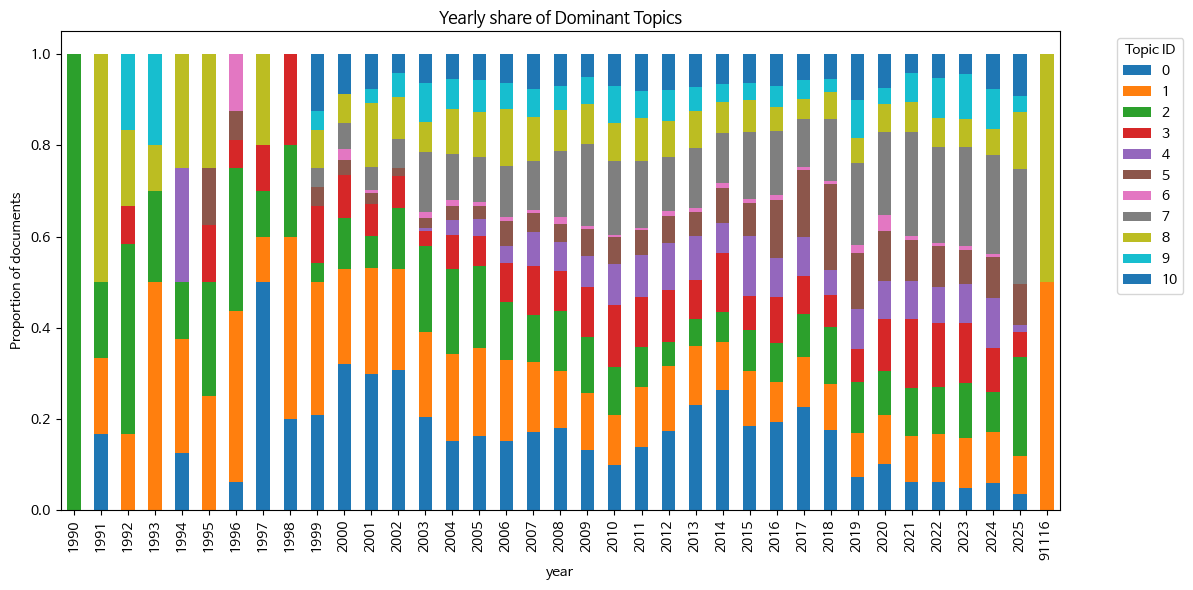

In [48]:
# 1) 연-토픽 교차표: 행=year, 열=DominantTopic, 값=건수
crosstab = (df
            .groupby(['year', 'DTM_DominantTopic'])
            .size()                         # 건수
            .unstack(fill_value=0)          # 열 = 토픽 ID
           )

# 2) 비율로 변환
ratio = crosstab.div(crosstab.sum(axis=1), axis=0)

# 3) 스택 막대
ratio.plot(kind='bar', stacked=True, figsize=(12,6))
plt.ylabel('Proportion of documents')
plt.title('Yearly share of Dominant Topics')
plt.legend(title='Topic ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


✅ 토픽별 가중치 변화가 'Topic_Strength_Over_Time.xlsx'에 저장됨


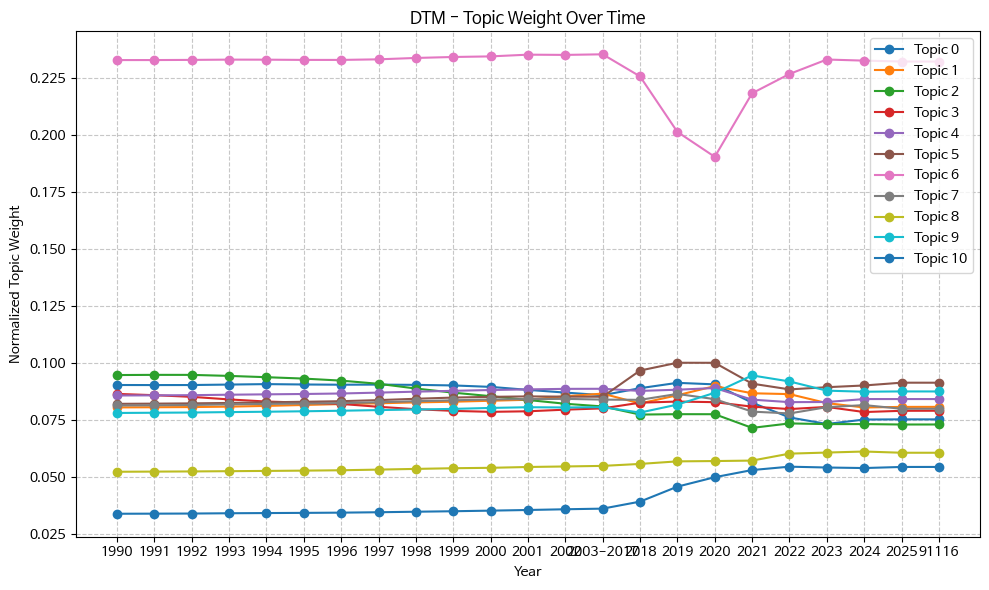

In [49]:
##############################################################################
# 16) 시점별 토픽 강도 (가중치 합) 및 시각화
##############################################################################
df_topic_words["abs_weight"] = df_topic_words["Weight"].abs()
df_topic_strength = (
    df_topic_words
    .groupby(["Topic","Year"], as_index=False)["abs_weight"]
    .sum()
    .rename(columns={"abs_weight":"Topic_Weight_Sum"})
)
df_topic_strength["Topic_Weight_Norm"] = df_topic_strength.groupby("Year")["Topic_Weight_Sum"].transform(
    lambda x: x / x.sum()
)
df_topic_strength.to_excel("Topic_Strength_Over_Time.xlsx", index=False)
print("\n✅ 토픽별 가중치 변화가 'Topic_Strength_Over_Time.xlsx'에 저장됨")

plt.figure(figsize=(10,6))
for t_id in sorted(df_topic_strength["Topic"].unique()):
    subset = df_topic_strength[df_topic_strength["Topic"] == t_id].copy()
    subset.sort_values("Year", inplace=True)
    label_name = f"Topic {t_id}"
    plt.plot(subset["Year"], subset["Topic_Weight_Norm"], marker='o', label=label_name)
plt.title("DTM - Topic Weight Over Time")
plt.xlabel("Year")
plt.ylabel("Normalized Topic Weight")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("Topic_Weight_Trend.png", dpi=300)
plt.show()

Method 1 - Document Topic Distribution (first 5 documents):
     Topic0    Topic1    Topic2    Topic3    Topic4    Topic5    Topic6  \
0  0.000690  0.043546  0.220376  0.074016  0.064313  0.000690  0.000690   
1  0.001685  0.167094  0.001685  0.296004  0.001685  0.210249  0.047127   
2  0.003036  0.195323  0.263629  0.445711  0.003035  0.074089  0.003035   
3  0.331936  0.003370  0.173094  0.003370  0.003370  0.137139  0.003370   
4  0.297632  0.332658  0.139412  0.000565  0.000565  0.000565  0.039401   

     Topic7    Topic8    Topic9   Topic10  
0  0.000690  0.255312  0.338987  0.000690  
1  0.001685  0.028346  0.242755  0.001685  
2  0.003035  0.003035  0.003035  0.003035  
3  0.003370  0.003370  0.152591  0.185020  
4  0.033560  0.062835  0.026739  0.066066  
✅ 문서별 토픽 점수가 'Document_Topic_Distribution.xlsx'로 저장되었습니다.
⚠ Colab 환경이 아닙니다. 파일은 로컬에 저장되었습니다.
Edge threshold (80th percentile): 0.007081391869737709


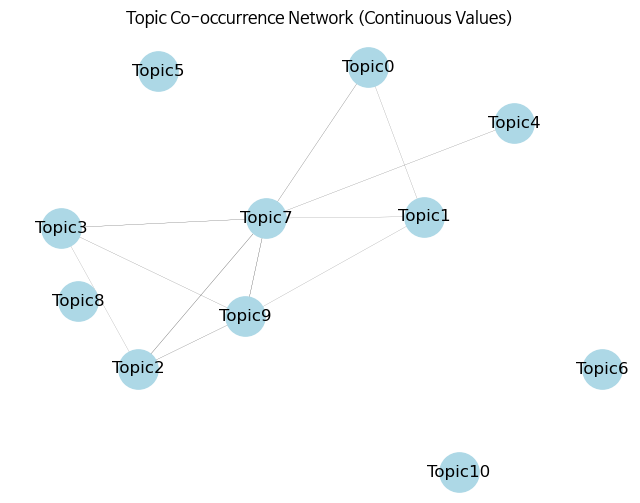

✅ 토픽 동시 출현 네트워크가 'topic_cooccurrence_network.pkl'에 저장됨
Model perplexity: -7.9310868938611225
C_v coherence: 0.5326305359380764


In [50]:
##############################################################################
# 17) 토픽 동시 출현 네트워크 구축 및 시각화 (연속값 기반)
##############################################################################
# LDA 모델 학습 (LDA 기반)
lda_model_method1 = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=best_k,
    passes=10,
    iterations=300,
    random_state=42
)

# 문서별 토픽 점수 산출
doc_topic_scores_method1 = []
for doc in corpus:
    doc_topics = lda_model_method1.get_document_topics(doc, minimum_probability=0)
    vec = np.zeros(lda_model_method1.num_topics)
    for topic_id, prob in doc_topics:
        vec[topic_id] = prob
    doc_topic_scores_method1.append(vec)

doc_topic_matrix_method1 = pd.DataFrame(doc_topic_scores_method1,
                                          columns=[f"Topic{i}" for i in range(lda_model_method1.num_topics)])
print("Method 1 - Document Topic Distribution (first 5 documents):")
print(doc_topic_matrix_method1.head())

# 문서별 토픽 점수를 엑셀로 저장 (다운로드 가능)
doc_topic_matrix_method1.to_excel("Document_Topic_Distribution.xlsx", index=False)
print("✅ 문서별 토픽 점수가 'Document_Topic_Distribution.xlsx'로 저장되었습니다.")

try:
    from google.colab import files
    files.download("Document_Topic_Distribution.xlsx")
    print("✅ 파일이 다운로드되었습니다.")
except ImportError:
    print("⚠ Colab 환경이 아닙니다. 파일은 로컬에 저장되었습니다.")

# 연속값을 사용한 토픽 동시 출현 행렬 계산
# 각 문서의 토픽 점수 벡터의 외적을 누적하면, 두 토픽이 동시에 높은 값을 가지는 정도를 반영할 수 있음
num_docs = doc_topic_matrix_method1.shape[0]
# Matrix multiplication: (doc_topic_matrix_method1.T dot doc_topic_matrix_method1) gives the sum over documents of product of scores.
co_occurrence_cont = doc_topic_matrix_method1.T.dot(doc_topic_matrix_method1) / num_docs

# 임계값: 80번째 백분위수 계산 (연속값에도 적용)
edge_threshold = np.percentile(co_occurrence_cont.values[np.triu_indices_from(co_occurrence_cont, k=1)], 80)
print("Edge threshold (80th percentile):", edge_threshold)

# 임계값 이하의 값은 0으로 처리하여 네트워크 구성
filtered_co_occurrence = co_occurrence_cont.copy()
filtered_co_occurrence[filtered_co_occurrence < edge_threshold] = 0

# 네트워크 구축
G_topic = nx.Graph()
topics = list(co_occurrence_cont.index)
for topic in topics:
    G_topic.add_node(topic)
for i, t1 in enumerate(topics):
    for j, t2 in enumerate(topics):
        if j <= i:
            continue
        weight = filtered_co_occurrence.loc[t1, t2]
        if weight > 0:
            G_topic.add_edge(t1, t2, weight=weight)

# 네트워크 시각화
plt.figure(figsize=(8,6))
pos = nx.spring_layout(G_topic, seed=42)
edge_weights = [G_topic[u][v]['weight']*10 for u, v in G_topic.edges()]  # 가중치 배율 조정
nx.draw_networkx_nodes(G_topic, pos, node_size=800, node_color='lightblue')
nx.draw_networkx_edges(G_topic, pos, width=edge_weights)
nx.draw_networkx_labels(G_topic, pos, font_size=12)
plt.title("Topic Co-occurrence Network (Continuous Values)")
plt.axis("off")
plt.show()

with open("topic_cooccurrence_network.pkl", "wb") as f:
    pickle.dump(G_topic, f)
print("✅ 토픽 동시 출현 네트워크가 'topic_cooccurrence_network.pkl'에 저장됨")

# 1. Perplexity
print("Model perplexity:", lda_model_method1.log_perplexity(corpus))

# 2. Topic coherence (c_v)
from gensim.models import CoherenceModel
cm = CoherenceModel(model=lda_model_method1,
                    texts=[toks for toks in df['tokens']],   # 토큰 리스트
                    dictionary=dictionary,
                    coherence='c_v')
print("C_v coherence:", cm.get_coherence())

# 3. pyLDAvis (HTML)
import pyLDAvis, pyLDAvis.gensim_models
vis = pyLDAvis.gensim_models.prepare(lda_model_method1, corpus, dictionary)
pyLDAvis.save_html(vis, 'lda_vis.html')



In [ ]:
# ──────────────────────────────────────────────────────────────
# 17-A) 원본 메타(샘플데이터_ver2..xlsx)와 토픽 확률 결합 후 저장
# ──────────────────────────────────────────────────────────────
import pandas as pd
from pathlib import Path

# 1) 경로 지정
META_PATH  = Path(r"C:\Users\wooji\Desktop\DTM_statement per actor\statement per actor_statement only.xlsx")
TOPIC_OUT  = Path(r"C:\Users\wooji\Desktop\DTM_statement per actor\LDA_Document_Topic_Distribution_full.xlsx")

# 2) 원본 메타 파일 읽기
df_meta = pd.read_excel(META_PATH)

# 3) doc_topic_matrix_method1 (DataFrame)에는 이미 토픽 확률이 들어 있음
#    · ID 열이 메타에도 있다면 키로 병합
#    · ID가 없다면 "행 순서가 동일"하다는 가정 하에 그냥 붙이기

KEY_COL = 'ID'                 # 실제 고유 식별자 열 이름으로 수정!
if KEY_COL in df_meta.columns:
    # 3-a) 안전: ID 기준 one-to-one 병합
    df_topic = doc_topic_matrix_method1.copy()
    df_topic[KEY_COL] = df_meta[KEY_COL]          # 동일 순서라면 이렇게 ID 부여
    df_full  = (df_meta
                .merge(df_topic, on=KEY_COL, how='left', validate='one_to_one'))
else:
    # 3-b) 순서 동일할 때: 열 방향으로 concat
    df_full = pd.concat([df_meta.reset_index(drop=True),
                         doc_topic_matrix_method1.reset_index(drop=True)],
                        axis=1)

# 4) 저장
df_full.to_excel(TOPIC_OUT, index=False)
print(f"✅ 메타 + 토픽 확률 통합 파일 저장 → {TOPIC_OUT}")


✅ 메타 + 토픽 확률 통합 파일 저장 → C:\Users\wooji\Desktop\DTM_statement per actor\LDA_Document_Topic_Distribution_full.xlsx
